In [1]:
import random
import gym
import time
import logging
import gym_minigrid
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
from mxnet import nd, autograd
from mxnet import gluon
from IPython import display
from memory import Memory
from utils import preprocess
from model.simple_stack import SimpleStack

/home/seventheli/anaconda/lib/python3.8/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.10.2+cu102` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


### Summary of the algorithm
#### Update Network
* Draw batches of tuples from the replay buffer: $(\phi,r,a,\phi')$.
* Define the following loss
$$\Large(\small Q(\phi,a,\theta)-r-Q(\phi',argmax_{a'}Q(\phi',a',\theta),\theta^-)\Large)^2$$
* Where $\theta^-$ is the parameter of the target network.( Set $Q(\phi',a',\theta^-)$ to zero if $\phi$ is the preprocessed termination state). 
* Update the $\theta$
* Update the $\theta^-$ once in a while








## Set the hyper-parameters

In [2]:
# frame channel
channel = 1
# The size of the batch to learn the Q-function
batch_size = 8
# Resize the raw input frame to square frame of size 80 by 80
image_size = 84
# Skip 4-1 raw frames between steps
skip_frame = 1
# The size of replay buffer; set it to size of your memory (.5M for 50G available memory)
replay_buffer_size = 50000
# 50K * 16 Frame * 3 Channel = 38GB
# With Freq of 1/4-step update the Q-network
learning_frequency = 4
# Each state is formed as a concatenation 4 step frames [f(t-12),f(t-8),f(t-4),f(t)]
frame_len = 16
# Update the target network each 10000 steps
target_update = 10000
# Minimum level of stochasticity of policy (epsilon)-greedy
epsilon_min = 0.01
# The number of step it take to linearly anneal the epsilon to it min value
annealing_end = 1000000.
# The discount factor
gamma = 0.99
# Start to back propagated through the network, learning starts
replay_start_size = 50000
# Run uniform policy for first 30 times step of the beginning of the game
no_op_max = 8
# Number episode to run the algorithm
num_episode = 10000000
max_frame = 200000000
# RMSprop learning rate
lr = 0.00005
# RMSprop gamma1
gamma1 = 0.95
# RMSprop gamma2
gamma2 = 0.95
# RMSprop epsilon bias
rms_eps = 0.01
# Enables gpu if available, if not, set it to mx.cpu()
ctx = mx.gpu()

In [3]:
env_name = 'MiniGrid-Empty-Random-6x6-v0'
env = gym.make(env_name)
num_action = 3
manualSeed = 1
mx.random.seed(manualSeed)
env_name = env_name + "-Map"

In [4]:
dqn = SimpleStack(num_action, frame_len, channel=channel)
dqn.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)
trainer = gluon.Trainer(
    dqn.collect_params(), 'RMSProp',
    {'learning_rate': lr, 'gamma1': gamma1, 'gamma2': gamma2, 'epsilon': rms_eps, 'centered': True})
dqn.collect_params().zero_grad()

In [5]:
target_dqn = SimpleStack(num_action, frame_len, channel=channel)
target_dqn.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)

In [6]:
loss_f = mx.gluon.loss.L2Loss(batch_axis=0)
# Counts the number of steps so far
frame_counter = 0.
# Counts the number of annealing steps
annealing_count = 0.
# Counts the number episodes so far
epis_count = 0.
# Initialize the replay buffer
replay_memory = Memory(replay_buffer_size, frame_len, channel)
tot_clipped_reward = []
tot_reward = []
frame_count_record = []
t_record = []
moving_average_clipped = 0.
moving_average = 0.

### Train the model

In [7]:
def rew_clipper(row, history):
    counter = 0
    _ = list(reversed(history))[0]
    for i in list(reversed(history))[1:]:
        if i == _:
            counter += 1
        else:
            break
    return (row- 0.0001 * counter) * 100

def render_image(frame, render):
    if render:
        plt.imshow(frame)
        plt.show()
        display.clear_output(wait=True)
        time.sleep(.1)

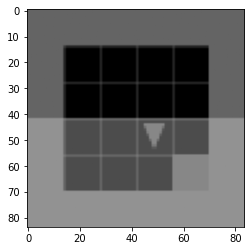

In [8]:
state, current_frame = preprocess(env.render(False), image_size, channel, frame_len, initial_state=True)
# _ = current_frame.asnumpy().transpose([1,2,0])
_ = np.concatenate([current_frame.asnumpy(), current_frame.asnumpy(), current_frame.asnumpy()]).transpose([1,2,0])
render_image(_, True)

In [9]:
 # Whether to render Frames and show the game
_render = False
while epis_count < max_frame:
    cum_clipped_reward = 0
    cum_reward = 0
    env.reset()
    next_frame = env.env.render(False)
    # next_frame = env.env.get_obs_render(env.env.gen_obs()["image"])
    state, current_frame = preprocess(next_frame, image_size, channel, frame_len, initial_state=True)
    t = 0.
    done = False
    initial_state = True
    location = [env.env.agent_pos.tolist()]
    while not done:
        previous_state = state
        # show the frame
        render_image(current_frame.asnumpy().transpose([1,2,0]), _render)
        sample = random.random()
        if frame_counter > replay_start_size:
            annealing_count += 1
        if frame_counter == replay_start_size:
            print("annealing and learning are started tot = %.4f" % moving_average)
        eps = np.maximum(1. - annealing_count / annealing_end, epsilon_min)

        effective_eps = eps
        if t < no_op_max:
            effective_eps = 1.
        step_count = env.env.max_steps - env.env.step_count
        # epsilon greedy policy
        if sample < effective_eps:
            action = random.randint(0, num_action - 1)
        else:
            data = [nd.array(state.reshape([1, frame_len * channel, image_size, image_size]), ctx), nd.array([step_count], ctx)]
            action = int(nd.argmax(dqn(*data), axis=1).as_in_context(mx.cpu()).asscalar())
            
        # Skip frame
        rew = 0
        for skip in range(skip_frame):
            next_frame, reward, done, _ = env.step(action)
            render_image(next_frame, _render)
            cum_clipped_reward += rew_clipper(reward, location)
            rew += reward
            location.append(env.env.agent_pos.tolist())
        cum_reward += rew
        
        # Reward clipping
        reward = rew_clipper(rew, location)
        
        # End Reward clipping
        
        # _ = env.env.get_obs_render(env.env.gen_obs()["image"])
        _ = env.env.render(False)
        state, current_frame = preprocess(_, image_size, channel, frame_len, current_state=state) 
        replay_memory.push((previous_state * 255.).astype('uint8'), action, (state * 255.).astype('uint8'), reward, done, step_count)
        # Train
        if frame_counter > replay_start_size and frame_counter % learning_frequency == 0:
            batch = replay_memory.sample(batch_size, ctx)
            batch_state = batch.state.astype('float32') / 255
            batch_state_next = batch.state_next.astype('float32') / 255
            batch_action = batch.action.astype('uint8')
            batch_battery  = batch.battery
            batch_reward = batch.reward
            batch_finish = batch.finish
            with autograd.record():
                argmax_Q = nd.argmax(dqn(batch_state_next, batch_battery),axis = 1).astype('uint8')
                Q_sp = nd.pick(target_dqn(batch_state_next, batch_battery),argmax_Q,1)
                Q_sp = Q_sp*(nd.ones(batch_size,ctx = ctx)-batch_finish)
                Q_s_array = dqn(batch_state, batch_battery)
                Q_s = nd.pick(Q_s_array,batch_action,1)
                loss = nd.mean(loss_f(Q_s ,  (batch_reward + gamma *Q_sp)))
            loss.backward()
            trainer.step(batch_size)
        t += 1
        frame_counter += 1
        # Save the model and update Target model
        if frame_counter >replay_start_size and frame_counter % target_update == 0:
            check_point = frame_counter / (target_update * 100)
            file_name = './data/target_%s_%d' % (env_name, int(check_point))
            dqn.save_parameters(file_name)
            target_dqn.load_parameters(file_name, ctx)
        if done:
            t_record.append(t+1)
            if epis_count % 50. == 0. :
                print('epis[%d],eps[%.4f],durat[%d],fnum=%d,tot_cl = %.4f , tot = %.4f' %(epis_count,eps,np.mean(t_record),frame_counter,moving_average_clipped,moving_average))
    epis_count += 1
    tot_clipped_reward = np.append(tot_clipped_reward, cum_clipped_reward)
    tot_reward = np.append(tot_reward, cum_reward)
    frame_count_record = np.append(frame_count_record,frame_counter)
    if epis_count > 100.:
        moving_average_clipped = np.mean(tot_clipped_reward[int(epis_count)-1-100:int(epis_count)-1])
        moving_average = np.mean(tot_reward[int(epis_count)-1-100:int(epis_count)-1])

epis[0],eps[1.0000],durat[145],fnum=144,tot_cl = 0.0000 , tot = 0.0000
epis[50],eps[1.0000],durat[80],fnum=4051,tot_cl = 0.0000 , tot = 0.0000
epis[100],eps[1.0000],durat[81],fnum=8100,tot_cl = 0.0000 , tot = 0.0000
epis[150],eps[1.0000],durat[81],fnum=12117,tot_cl = 44.6279 , tot = 0.4792
epis[200],eps[1.0000],durat[82],fnum=16460,tot_cl = 40.5433 , tot = 0.4405
epis[250],eps[1.0000],durat[79],fnum=19724,tot_cl = 45.8494 , tot = 0.4884
epis[300],eps[1.0000],durat[80],fnum=24071,tot_cl = 46.2263 , tot = 0.4928
epis[350],eps[1.0000],durat[82],fnum=28545,tot_cl = 39.1195 , tot = 0.4279
epis[400],eps[1.0000],durat[81],fnum=32413,tot_cl = 41.6852 , tot = 0.4514
epis[450],eps[1.0000],durat[81],fnum=36477,tot_cl = 43.0607 , tot = 0.4667
epis[500],eps[1.0000],durat[80],fnum=39864,tot_cl = 48.2643 , tot = 0.5161
epis[550],eps[1.0000],durat[81],fnum=44191,tot_cl = 46.5491 , tot = 0.4964
epis[600],eps[1.0000],durat[82],fnum=48706,tot_cl = 36.8357 , tot = 0.4095
annealing and learning are started

epis[5350],eps[0.7639],durat[54],fnum=286120,tot_cl = 74.9914 , tot = 0.7620
epis[5400],eps[0.7616],durat[54],fnum=288403,tot_cl = 70.8746 , tot = 0.7233
epis[5450],eps[0.7600],durat[54],fnum=289969,tot_cl = 74.5803 , tot = 0.7585
epis[5500],eps[0.7582],durat[54],fnum=291756,tot_cl = 78.2484 , tot = 0.7937
epis[5550],eps[0.7565],durat[53],fnum=293537,tot_cl = 76.3275 , tot = 0.7747
epis[5600],eps[0.7551],durat[53],fnum=294937,tot_cl = 78.8570 , tot = 0.7984
epis[5650],eps[0.7536],durat[53],fnum=296353,tot_cl = 81.7979 , tot = 0.8263
epis[5700],eps[0.7522],durat[53],fnum=297777,tot_cl = 81.0892 , tot = 0.8206
epis[5750],eps[0.7503],durat[53],fnum=299747,tot_cl = 77.5724 , tot = 0.7869
epis[5800],eps[0.7486],durat[52],fnum=301392,tot_cl = 76.5532 , tot = 0.7759
epis[5850],eps[0.7472],durat[52],fnum=302796,tot_cl = 79.7672 , tot = 0.8071
epis[5900],eps[0.7457],durat[52],fnum=304338,tot_cl = 80.3587 , tot = 0.8131
epis[5950],eps[0.7441],durat[52],fnum=305880,tot_cl = 79.7855 , tot = 0.8077

epis[10700],eps[0.6073],durat[42],fnum=442695,tot_cl = 76.1269 , tot = 0.7730
epis[10750],eps[0.6055],durat[42],fnum=444452,tot_cl = 77.9987 , tot = 0.7902
epis[10800],eps[0.6037],durat[42],fnum=446338,tot_cl = 75.6072 , tot = 0.7688
epis[10850],eps[0.6020],durat[42],fnum=448045,tot_cl = 75.9441 , tot = 0.7729
epis[10900],eps[0.6000],durat[42],fnum=449983,tot_cl = 76.0055 , tot = 0.7721
epis[10950],eps[0.5981],durat[42],fnum=451871,tot_cl = 74.6350 , tot = 0.7606
epis[11000],eps[0.5964],durat[42],fnum=453596,tot_cl = 75.9173 , tot = 0.7730
epis[11050],eps[0.5943],durat[42],fnum=455690,tot_cl = 74.4819 , tot = 0.7578
epis[11100],eps[0.5927],durat[42],fnum=457316,tot_cl = 75.7450 , tot = 0.7716
epis[11150],eps[0.5911],durat[42],fnum=458919,tot_cl = 78.6669 , tot = 0.7988
epis[11200],eps[0.5891],durat[42],fnum=460854,tot_cl = 76.1261 , tot = 0.7741
epis[11250],eps[0.5875],durat[42],fnum=462482,tot_cl = 76.5154 , tot = 0.7788
epis[11300],eps[0.5854],durat[42],fnum=464622,tot_cl = 74.7671 ,

KeyboardInterrupt: 

### Plot the overall performace

In [ ]:
num_epis_count = epis_count - 0
bandwidth = 100  # Moving average bandwidth
total_clipped = np.zeros(int(num_epis_count) - bandwidth)
total_rew = np.zeros(int(num_epis_count) - bandwidth)
for i in range(int(num_epis_count) - bandwidth):
    total_clipped[i] = np.sum(tot_clipped_reward[i:i + bandwidth]) / bandwidth
    total_rew[i] = np.sum(tot_reward[i:i + bandwidth]) / bandwidth
t = np.arange(int(num_epis_count) - bandwidth)
fig = plt.figure()
belplt = plt.plot(t, total_rew[0:int(num_epis_count) - bandwidth], "r", label="Return")
plt.legend()  #handles[likplt,belplt])
print('Running after %d number of episodes' % epis_count)
plt.xlabel("Number of episode")
plt.ylabel("Average Reward per episode")
plt.show()
fig.savefig('Grid_DDQN.png')
fig = plt.figure()
likplt = plt.plot(t, total_clipped[0:num_episode - bandwidth], "b", label="Clipped Return")
plt.legend()  #handles[likplt,belplt])
plt.xlabel("Number of episode")
plt.ylabel("Average clipped Reward per episode")
plt.show()
fig.savefig('Grid_Clipped.png')